In [1]:
# https://fred.stlouisfed.org/series/IPN31152N

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



%matplotlib inline

In [3]:
df = pd.read_csv('data/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [5]:
df.head(5)

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [6]:
df.columns = ['Production']

<AxesSubplot:xlabel='DATE'>

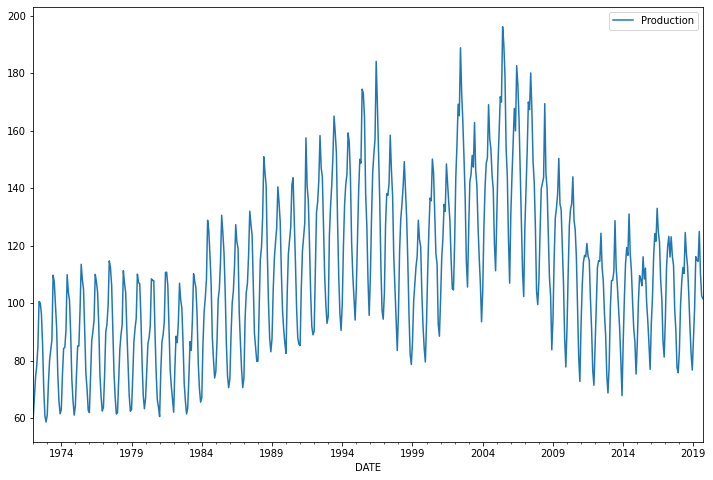

In [7]:
df.plot(figsize=(12,8))

Train Test Split

In [8]:
len(df)

573

In [9]:
test_size = 24
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [16]:
length = 18
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

Create the model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [18]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [20]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [23]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20


C:\Users\antho\AppData\Local\Temp\ipykernel_21228\3502985036.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


531/531 [==============================] - 41s 72ms/step - loss: 0.0260 - val_loss: 0.0030
Epoch 2/20
531/531 [==============================] - 39s 73ms/step - loss: 0.0080 - val_loss: 0.0013
Epoch 3/20
531/531 [==============================] - 43s 82ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 4/20
531/531 [==============================] - 44s 83ms/step - loss: 0.0037 - val_loss: 0.0040


Evaluate the model

In [30]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:>

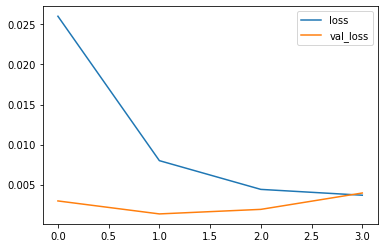

In [24]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [26]:
true_predictions = scaler.inverse_transform(test_predictions)

In [27]:
test['Predictions'] = true_predictions

C:\Users\antho\AppData\Local\Temp\ipykernel_21228\4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [28]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,93.310246
2017-11-01,77.4378,89.125474
2017-12-01,75.8118,90.818454
2018-01-01,83.4343,101.033855
2018-02-01,99.4899,114.048050
2018-03-01,107.3152,123.506748
2018-04-01,112.4309,130.805071
2018-05-01,110.3544,135.092963
2018-06-01,124.5841,133.047280


<AxesSubplot:xlabel='DATE'>

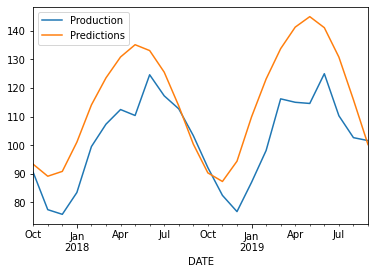

In [29]:
test.plot()

In [31]:
np.sqrt(mean_squared_error(test['Production'],test['Predictions']))

16.473042121267856